In [1]:
%matplotlib inline

This is a sort of copy of errors2.py for testing.

In [4]:
import numpy as np # for array handling
import glob # for searching for files
from astropy.io import fits as pyfits # reads fits files (is from astropy)
from scipy import ndimage # for gaussian blur
import math
import os
import sys

In [5]:
def set_params():
## ----------===============================================---------
## ----------============= Input parameters  ===============---------
## ----------===============================================---------
    glamdring = False
    quiet = True
    gas = 3 # 0   No gas emission lines
            # 1   Probe ionised gas
            # 2   Seperate gases heated by shocks (OIII and NI) and by SF gas
            #     (Hb and Hd)
            # 3   All gas seperate.
    reps = 0 ## number of monte carlo reps per bin.
    discard = 2
    set_range = np.array([4200,10000])
    FWHM_gal = 4*0.71 # The fibre FWHM on VIMOS is
                           # about 4px with a dispersion of
                           # 0.571A/px. (From: http://www.eso.org
                           # /sci/facilities/paranal/instruments
                           # /vimos/inst/ifu.html)
    stellar_moments = 4 # number of componants to calc with ppxf (see 
                        # keyword moments in ppxf.pro for more details)
    gas_moments = 4
    degree = 4  # order of addative Legendre polynomial used to 
                #; correct the template continuum shape during the fit
    return glamdring, quiet, gas, reps, discard, set_range, FWHM_gal, \
        stellar_moments, gas_moments, degree

In [6]:
def set_lines (lines, logLam_temp, FWHM_gal):
# In this routine all lines are free to have independent intensities.
# One can fix the intensity ratio of different lines (e.g. the [OIII] doublet)
# by placing them in the same emission template
    lam = np.exp(logLam_temp)
#    lines = lines[where((lines gt min(lam)) and (lines lt max(lam)))]
    sigma = FWHM_gal/2.355 # Assumes instrumental sigma is constant in Angstrom
    emission_lines = np.zeros((len(logLam_temp),len(lines)))
    for j in range(len(lines)):
        emission_lines[:,j] = np.exp(-0.5*np.power((lam - lines[j])/sigma,2))
    return emission_lines

In [7]:
def use_templates(galaxy, glamdring=False):
    if glamdring:
        template_weighting = '/users/warrenj/analysis/' + galaxy + \
	    '/templates.txt' 
    else:
        template_weighting = '/Data/vimos/analysis/' + galaxy + \
	    '/templates.txt' 

    templatesToUse = np.loadtxt(template_weighting, usecols=(0,), dtype='i')
    return templatesToUse

In [8]:
def determine_goodpixels(logLam, lamRangeTemp, vel, z, gas=False):
# warrenj 20150905 Copied from ppxf_determine_goodPixels.pro
#
# PPXF_DETERMINE_GOODPIXELS: Example routine to generate the vector of
#	goodPixels to be used as input keyword for the routine
#	PPXF. This is useful to mask gas emission lines or atmospheric
#	absorptions. It can be trivially adapted to mask different
#	lines. 
# 
# INPUT PARAMETERS:
# - LOGLAM: Natural logarithm ALOG(wave) of the wavelength in Angstrom 
#     of each pixel of the log rebinned *galaxy* spectrum.
# - LAMRANGETEMP: Two elements vectors [lamMin2,lamMax2] with the
#     minimum and maximum wavelength in Angstrom in the stellar
#     *template* used in PPXF. 
# - VEL: Estimate of the galaxy velocity in km/s.
# 
# V1.0: Michele Cappellari, Leiden, 9 September 2005
# V1.01: Made a separate routine and included additional common
#   emission lines. MC, Oxford 12 January 2012
# V1.02: Included more lines. MC, Oxford, 7 Januray 2014

    c = 299792.458 # speed of light in km/s

## 20150617 warrenj Added Telluric lines (tell) at 5199 (is a blended sky
## line)

 
#dv = lines*0+800d # width/2 of masked gas emission region in km/s
    dv = 800 # width/2 of masked gas emission region in km/s
#    flag = bytearray([0]*len(logLam))
    flag = logLam < 0

# Marks telluric line
    tell = 5199
    flag |= (logLam > np.log(tell) - z - dv/c) \
        & (logLam < np.log(tell) - z + dv/c) 

    if not gas:
#                         -----[OII]-----   Hdelta    Hgamma   Hbeta;
        lines = np.array([3726.03, 3728.82, 4101.76, 4340.47, 4861.33, \
#            -----[OIII]----- ----??----   [OI]   
            4958.92, 5006.84, 5528, 5535, 6300.30, \
#           -----[NII]-----  Halpha   -----[SII]-----   
            6548.03, 6583.41,  6562.80, 6716.47, 6730.85])

        for j in range(len(lines)):
            flag |= (logLam > np.log(lines[j]) + (vel- dv)/c) \
                & (logLam < np.log(lines[j]) + (vel+ dv)/c)


    flag |= logLam < np.log(lamRangeTemp[0]) + (vel + 900)/c # Mask edges of
    flag |= logLam > np.log(lamRangeTemp[1]) + (vel - 900)/c # stellar library


    flag[0:3] = 1 # Mask edge of data
    flag[-4:]= 1 # to remove edge effects
    return np.where(flag == 0)[0]

In [9]:
glamdring, quiet, gas, reps, discard, set_range, FWHM_gal, \
        stellar_moments, gas_moments, degree = set_params()

In [17]:
galaxy = 'ngc3557'
bin = 686

In [18]:
dir = '/Data/vimos/'
dir2 = '/Data/idl_libraries/'
import matplotlib.pyplot as plt # used for plotting
from ppxf import ppxf
import ppxf_util as util

In [19]:
data_file = dir + "analysis/galaxies.txt"
# different data types need to be read separetly
z_gals, vel_gals, sig_gals, x_gals, y_gals = np.loadtxt(data_file, unpack=True, skiprows=1, usecols=(1,2,3,4,5))
galaxy_gals = np.loadtxt(data_file, skiprows=1, usecols=(0,),dtype=str)
i_gal = np.where(galaxy_gals==galaxy)[0][0]
vel = vel_gals[i_gal]
sig = sig_gals[i_gal]
z = z_gals[i_gal]

tessellation_File = dir + "analysis/%s/" %(galaxy) +\
        "voronoi_2d_binning_output.txt"
tessellation_File2 = dir + "analysis/%s/" %(galaxy) +\
        "voronoi_2d_binning_output2.txt"

FWHM_gal = FWHM_gal/(1+z) # Adjust resolution in Angstrom

In [20]:
## ----------========= Reading Tessellation  =============---------

## Reads the txt file containing the output of the binning_spaxels
## routine. 
x,y,bin_num = np.loadtxt(tessellation_File, usecols=(0,1,2), \
        unpack=True, skiprows=1)

n_bins = max(bin_num) + 1
## Contains the order of the bin numbers in terms of index number.
order = np.sort(bin_num)

In [21]:
## ----------========= Reading the spectrum  =============---------

dataCubeDirectory = glob.glob(dir+"cubes/%s.cube.combined.fits" % (galaxy)) 
        
galaxy_data, header = pyfits.getdata(dataCubeDirectory[0], 0, header=True)
galaxy_noise = pyfits.getdata(dataCubeDirectory[0], 1)

## write key parameters from header - can then be altered in future	
CRVAL_spec = header['CRVAL3']
CDELT_spec = header['CDELT3']
s = galaxy_data.shape

rows_to_remove = range(discard)
rows_to_remove.extend([s[1]-1-i for i in range(discard)])
cols_to_remove = range(discard)
cols_to_remove.extend([s[2]-1-i for i in range(discard)])

galaxy_data = np.delete(galaxy_data, rows_to_remove, axis=1)
galaxy_data = np.delete(galaxy_data, cols_to_remove, axis=2)
galaxy_noise = np.delete(galaxy_noise, rows_to_remove, axis=1)
galaxy_noise = np.delete(galaxy_noise, cols_to_remove, axis=2)

n_spaxels = len(galaxy_data[0,0,:])*len(galaxy_data[0,:,0])

In [57]:
## ----------========== Spatially Binning =============---------
spaxels_in_bin = np.where(bin_num == bin)[0]
n_spaxels_in_bin = len(spaxels_in_bin)

bin_lin_temp = np.zeros(s[0])
bin_lin_noise_temp = np.zeros(s[0])
bin_badpix_temp = np.zeros(s[0])

print spaxels_in_bin[0]

1276


1916 35.0 16.0


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


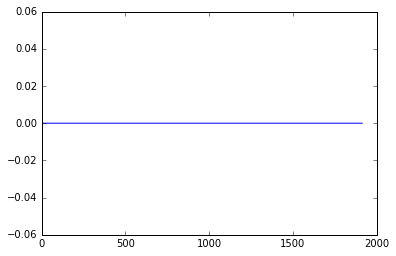

In [54]:
for i in range(n_spaxels_in_bin):
    x_i = x[spaxels_in_bin[i]]
    y_i = y[spaxels_in_bin[i]]
    print s[0],x_i, y_i
    for k in range(s[0]):
        bin_lin_temp[k] += galaxy_data[k,x_i,y_i]
        bin_lin_noise_temp[k] += galaxy_noise[k,x_i,y_i]**2
        bin_badpix_temp[k] += galaxy_badpix[k,x_i,y_i]

plt.plot(galaxy_data[:,35,16])

In [38]:
bin_lin_noise_temp = np.sqrt(bin_lin_noise_temp)

In [41]:
## --------======== Finding limits of the spectrum ========--------
## limits are the cuts in pixel units, while lamRange is the cuts in
## wavelength unis.
gap=12
ignore = int((5581 - CRVAL_spec)/CDELT_spec) + np.arange(-gap+1,gap)  
ignore2 = int((5199 - CRVAL_spec)/CDELT_spec) + np.arange(-gap+1,gap) 

## h is the spectrum with the peak enclosed by 'ignore' removed.
h = np.delete(bin_lin_temp, ignore)
h = np.delete(h,ignore2)

half = s[0]/2
a = np.delete(h,np.arange(-4,0)+len(h),None)/np.median(h[np.nonzero(h)]) - \
        h[4:]/np.median(h[np.nonzero(h)])
a = np.where(np.isfinite(a), a, 0)

if any(np.abs(a[:0.5*half]) > 0.2):
    lower_limit = max(np.where(np.abs(a[:0.5*half]) > 0.2)[0])
else: 
    lower_limit = -1
#        print str(i_gal) + ', ' + str(bin)

    
#    lower_limit = max(np.where(np.abs(a[:0.5*half]) > 0.2)[0])
if any(np.abs(a[1.5*half:]) > 0.2):
    upper_limit = min(np.where(np.abs(a[1.5*half:]) > 0.2)[0])+int(1.5*half)
else:
    upper_limit = -1
        
if upper_limit > ignore2[0]: upper_limit+=gap 
if upper_limit > ignore[0]: upper_limit+=gap



/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [42]:
if lower_limit < 0:
    lower_limit = min(np.where(a[:half] != 0)[0]) + 5
    if lower_limit < 0: lower_limit = 0

else:
   lower_limit +=5

if upper_limit > s[0]-1 or upper_limit < half:
    upper_limit = s[0]-6 
else:
    upper_limit += -5

ValueError: min() arg is an empty sequence

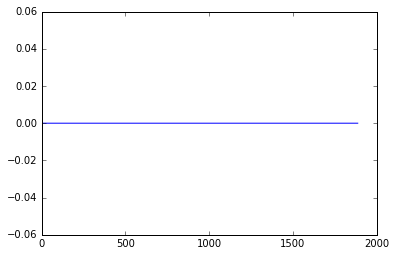

In [43]:
plt.plot(a)

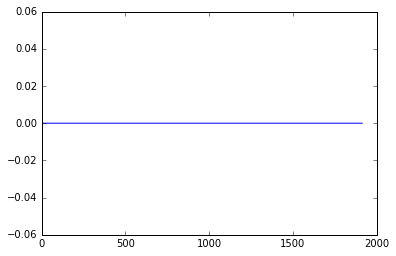

In [44]:
plt.plot(bin_lin_temp)

In [45]:
galaxy_badpix = pyfits.getdata(dataCubeDirectory[0], 3)
